# 1. Init Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

import qiskit
from qiskit.visualization import *

In [2]:
use_cuda = torch.cuda.is_available()

print('CUDA available:', use_cuda)

if use_cuda:
    device = torch.device('cuda')
    print('Training on GPU...')
else:
    device = torch.device('cpu')
    print('Training on CPU...')

CUDA available: True
Training on GPU...


# 2. Define Quantum Circuit and Layer

In [3]:
QC_outputs = ['000', '001', '010', '011', '100', '101', '110', '111']

In [4]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
                
            
        self.theta_0 = qiskit.circuit.Parameter('theta0')
        self.theta_1 = qiskit.circuit.Parameter('theta1')
        self.theta_2 = qiskit.circuit.Parameter('theta2')
        self.theta_3 = qiskit.circuit.Parameter('theta3')
        self.theta_4 = qiskit.circuit.Parameter('theta4')
        self.theta_5 = qiskit.circuit.Parameter('theta5')
        self.theta_6 = qiskit.circuit.Parameter('theta6')

        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta_0, all_qubits)
        self._circuit.cz(0,1)
        self._circuit.cz(1,2)
        self._circuit.ry(self.theta_1, 0)
        self._circuit.ry(self.theta_2, 1)
        self._circuit.ry(self.theta_3, 2)
        self._circuit.cz(0,1)
        self._circuit.cz(1,2)
        self._circuit.ry(self.theta_4, 0)
        self._circuit.ry(self.theta_5, 1)
        self._circuit.ry(self.theta_6, 2)

        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots,
                             parameter_binds = [{self.theta_0: thetas[0],
                                                 self.theta_1: thetas[1],
                                                 self.theta_2: thetas[2],
                                                 self.theta_3: thetas[3],
                                                 self.theta_4: thetas[4],
                                                 self.theta_5: thetas[5],
                                                 self.theta_6: thetas[6],}])
        counts = job.result().get_counts(self._circuit)
        
        expects = np.zeros(8)
        for k in range(8):
          key = QC_outputs[k]
          perc = counts.get(key, 0) /self.shots
          expects[k] = perc
        
        return expects

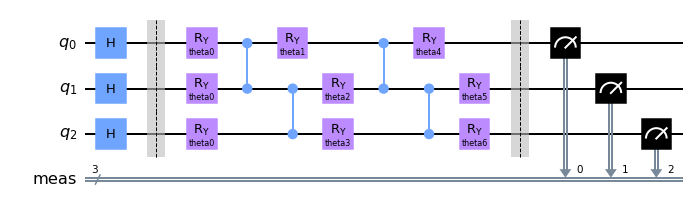

In [5]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(3, simulator, 100)
circuit._circuit.draw('mpl')

In [6]:
print(circuit._circuit.parameters)

{Parameter(theta0), Parameter(theta5), Parameter(theta3), Parameter(theta4), Parameter(theta6), Parameter(theta2), Parameter(theta1)}


In [7]:
circuit.run([1,2,1,4,5,6,8])

(array([0.03, 0.02, 0.73, 0.11, 0.03, 0.02, 0.05, 0.01]),
         ┌───┐ ░ ┌────────────┐   ┌────────────┐                 ┌────────────┐»
    q_0: ┤ H ├─░─┤ RY(theta0) ├─■─┤ RY(theta1) ├───────────────■─┤ RY(theta4) ├»
         ├───┤ ░ ├────────────┤ │ └────────────┘┌────────────┐ │ └────────────┘»
    q_1: ┤ H ├─░─┤ RY(theta0) ├─■───────■───────┤ RY(theta2) ├─■───────■───────»
         ├───┤ ░ ├────────────┤         │       ├────────────┤         │       »
    q_2: ┤ H ├─░─┤ RY(theta0) ├─────────■───────┤ RY(theta3) ├─────────■───────»
         └───┘ ░ └────────────┘                 └────────────┘                 »
 meas: 3/══════════════════════════════════════════════════════════════════════»
                                                                               »
 «                       ░ ┌─┐      
 «   q_0: ───────────────░─┤M├──────
 «        ┌────────────┐ ░ └╥┘┌─┐   
 «   q_1: ┤ RY(theta5) ├─░──╫─┤M├───
 «        ├────────────┤ ░  ║ └╥┘┌─┐
 «   q_2: ┤ RY(theta6) ├─░──

In [8]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        print(inputs)
        expectation_z = []
        for input in inputs:
            expectation_z.append(ctx.quantum_circuit.run(input.tolist()))
        result = torch.tensor(expectation_z).cuda()
        
        ctx.save_for_backward(inputs, result)
        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]).cuda() - torch.tensor([expectation_left]).cuda()
            gradients.append(gradient)
        
        # gradients = np.array([gradients]).T
        gradients = torch.tensor([gradients]).cuda()
        gradients = torch.transpose(gradients, 0, 1)

        # return torch.tensor([gradients]).float() * grad_output.float(), None, None
        return gradients.float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(3, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

# 3. Set Train and Test data

In [24]:
n_samples = 512
batch_size = 256 #increase

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

X_train.data = X_train.data[:n_samples]
X_train.targets = X_train.targets[:n_samples]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)


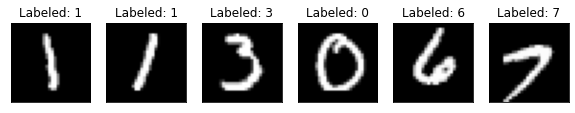

In [25]:
# check MNIST data

n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

images, targets = data_iter.__next__()


while n_samples_show > 0:
    axes[n_samples_show - 1].imshow(images[n_samples_show].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(int(targets[n_samples_show])))
    
    n_samples_show -= 1

In [26]:
n_samples = 2048

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

# idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
#                 np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[:n_samples]
X_test.targets = X_test.targets[:n_samples]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True)

# 4. Set Neural Network Model

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 7)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        #self.hybrid = [Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2) for i in range(10)]
        self.fc3 = nn.Linear(8,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        # x = x.view(-1, 256)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = torch.chunk(x, 10, dim=1)
        x = self.hybrid(x)
        x = x.type(dtype=torch.cuda.FloatTensor)
        #x = tuple([hy(x_) for hy, x_ in zip(self.hybrid, x)])
        x = self.fc3(x)
        return torch.cat((x, 1-x), -1)

In [17]:
model = Net().cuda()

summary(model, (1, 28, 28))

tensor([[-0.0780,  0.0806,  0.1372, -0.0658,  0.0585, -0.1076, -0.0986],
        [-0.0904,  0.0741,  0.1172, -0.0502,  0.0084, -0.0714, -0.0932]],
       device='cuda:0', grad_fn=<AddmmBackward>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2             [-1, 16, 8, 8]           2,416
         Dropout2d-3             [-1, 16, 4, 4]               0
            Linear-4                   [-1, 64]          16,448
            Linear-5                    [-1, 7]             455
            Hybrid-6                    [-1, 8]               0
            Linear-7                   [-1, 10]              90
Total params: 19,565
Trainable params: 19,565
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.07
Estimated

# 5. Train Model

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_func = nn.NLLLoss()
loss_func = nn.CrossEntropyLoss().cuda()

epochs = 50
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data.cuda()
        target = target.cuda()
        
        # Forward pass
        output = model(data).cuda()

        # print("data  ", data.size())
        # print("output", output.size())
        # print("target", target.size())

        # Calculating loss
        loss = loss_func(output, target)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

tensor([[-0.0971,  0.0749,  0.1031,  ...,  0.0144, -0.0792, -0.1457],
        [-0.1384,  0.0742,  0.1272,  ...,  0.0577, -0.0285, -0.0931],
        [-0.0537,  0.0723,  0.0946,  ..., -0.0009, -0.0661, -0.1151],
        ...,
        [-0.1251,  0.0943,  0.1140,  ...,  0.0121, -0.0413, -0.0929],
        [-0.0577,  0.0533,  0.1133,  ...,  0.0665, -0.1021, -0.0813],
        [-0.0586,  0.0535,  0.1001,  ...,  0.0145, -0.0647, -0.0930]],
       device='cuda:0', grad_fn=<AddmmBackward>)


ValueError: only one element tensors can be converted to Python scalars

In [ ]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')

# 6. Evaluate Model

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        
        data = data.cuda()
        target = target.cuda()

        output = model(data).cuda()
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100 / batch_size)
        )

In [ ]:
n_samples_show = 8
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        
        data_cuda = data.cuda()
        target_cuda = target.cuda()

        output_cuda = model(data_cuda).cuda()
        
        pred = output_cuda.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[count].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred[count].item()))
        
        count += 1